## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [211]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [212]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [213]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

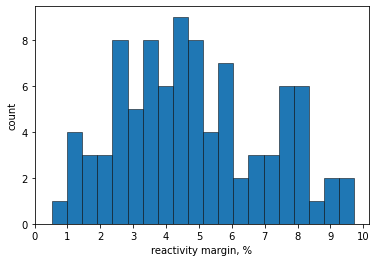

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [216]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [217]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

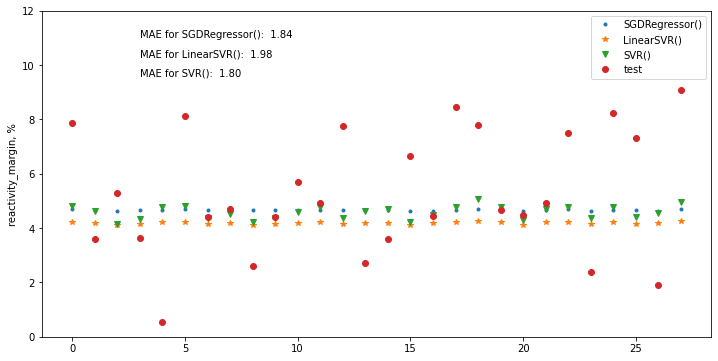

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [221]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [222]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [223]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

In [224]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [225]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 5min 31s


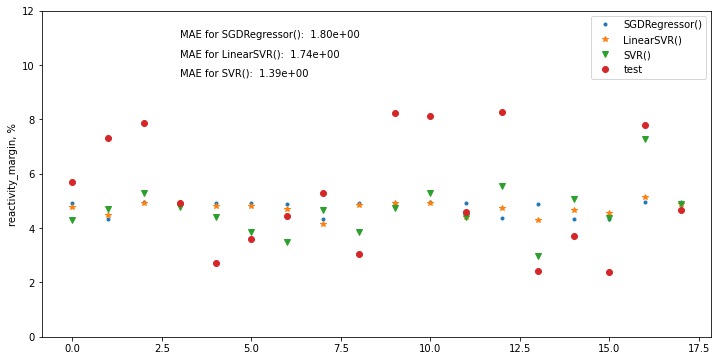

In [226]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost